<a href="https://colab.research.google.com/github/RomalPatel28/Romal_INFO5731_Fall2021/blob/main/In_class_exercise_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The seventh in-class-exercise (40 points in total, 10/20/2021)**

Question description: Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks:

## (1) (15 points) Generate K topics by using LDA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here: 

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [4]:
# Importing and installing the necessary packages
import nltk; nltk.download('stopwords')

!python3 -m spacy download en
!pip install pyLDAvis==2.1.2
!pip install gensim==3.8.3

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
     |████████████████████████████████| 12.0 MB 6.3 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [5]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [6]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [7]:
# from google.colab import drive
# drive.mount('/content/drive/MyDrive/inclass/romal_inclass4.csv')

In [8]:
import pandas as pd
df = pd.read_csv('romal_inclass4.csv', encoding= 'unicode_escape')
df

,Unnamed: 0,Title,Abstract
0,0,Data Streams: Algorithms and Applications,"In the data stream scenario, input arrives ve..."
1,1,Bayesian Data Analysis,I actually own a copy of Harold Jeffreysâs ...
2,2,Voronoi diagrams -- a survey of a fundamental ...,This paper presents a survey of the Voronoi d...
3,3,From Data Mining to Knowledge Discovery in Dat...,Data mining and knowledge discovery in databa...
4,4,Survey of clustering algorithms,Data analysis plays an indispensable role for...
...,...,...,...
995,995,Thresholding of statistical maps in functional...,Finding objective and effective thresholds f...
996,996,Maintaining knowledge about temporal intervals,The problem of representing temporal knowledg...
997,997,Status quo bias in decision making,"economics, rationality Most real decisions, u..."
998,998,Rough Sets.,Abstract. This article presents some general...


In [9]:
# Convert to list
data = df['Abstract'].tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

[' In the data stream scenario, input arrives very rapidly and there is '
 'limited memory to store the input. Algorithms have to work with one or few '
 'passes over the data, space less than linear in the input size or time '
 'significantly less than the input size. In the past few years, a new theory '
 'has emerg ']


In [10]:
#Tokenizing words and cleaning up text
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['in', 'the', 'data', 'stream', 'scenario', 'input', 'arrives', 'very', 'rapidly', 'and', 'there', 'is', 'limited', 'memory', 'to', 'store', 'the', 'input', 'algorithms', 'have', 'to', 'work', 'with', 'one', 'or', 'few', 'passes', 'over', 'the', 'data', 'space', 'less', 'than', 'linear', 'in', 'the', 'input', 'size', 'or', 'time', 'significantly', 'less', 'than', 'the', 'input', 'size', 'in', 'the', 'past', 'few', 'years', 'new', 'theory', 'has', 'emerg']]


In [11]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['in', 'the', 'data', 'stream', 'scenario', 'input', 'arrives', 'very', 'rapidly', 'and', 'there', 'is', 'limited', 'memory', 'to', 'store', 'the', 'input', 'algorithms', 'have', 'to', 'work', 'with', 'one', 'or', 'few', 'passes', 'over', 'the', 'data', 'space', 'less', 'than', 'linear', 'in', 'the', 'input', 'size', 'or', 'time', 'significantly', 'less', 'than', 'the', 'input', 'size', 'in', 'the', 'past', 'few', 'years', 'new', 'theory', 'has', 'emerg']


In [12]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [13]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['datum', 'stream', 'scenario', 'input', 'arrive', 'rapidly', 'limit', 'memory', 'store', 'input', 'algorithm', 'work', 'pass', 'data', 'space', 'less', 'linear', 'input', 'size', 'time', 'significantly', 'less', 'input', 'size', 'year', 'new', 'theory']]


In [14]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 4), (5, 2), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1)]]


In [15]:
id2word[0]
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('algorithm', 1),
  ('arrive', 1),
  ('data', 1),
  ('datum', 1),
  ('input', 4),
  ('less', 2),
  ('limit', 1),
  ('linear', 1),
  ('memory', 1),
  ('new', 1),
  ('pass', 1),
  ('rapidly', 1),
  ('scenario', 1),
  ('significantly', 1),
  ('size', 2),
  ('space', 1),
  ('store', 1),
  ('stream', 1),
  ('theory', 1),
  ('time', 1),
  ('work', 1),
  ('year', 1)]]

In [16]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [17]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.077*"model" + 0.077*"flow" + 0.038*"amount" + 0.038*"capture" + '
  '0.038*"bulk" + 0.038*"analytic" + 0.038*"time" + 0.038*"develop" + '
  '0.038*"paper" + 0.038*"function"'),
 (1,
  '0.005*"introduce" + 0.005*"line" + 0.005*"area" + 0.005*"arise" + '
  '0.005*"base" + 0.005*"comp" + 0.005*"current" + 0.005*"date" + '
  '0.005*"inadequate" + 0.005*"instant"'),
 (2,
  '0.083*"threshold" + 0.042*"rate" + 0.042*"objective" + 0.042*"perform" + '
  '0.042*"test" + 0.042*"need" + 0.042*"procedure" + 0.042*"standing" + '
  '0.042*"standard" + 0.042*"statistic"'),
 (3,
  '0.005*"introduce" + 0.005*"line" + 0.005*"area" + 0.005*"arise" + '
  '0.005*"base" + 0.005*"comp" + 0.005*"current" + 0.005*"date" + '
  '0.005*"inadequate" + 0.005*"instant"'),
 (4,
  '0.005*"introduce" + 0.005*"line" + 0.005*"area" + 0.005*"arise" + '
  '0.005*"base" + 0.005*"comp" + 0.005*"current" + 0.005*"date" + '
  '0.005*"inadequate" + 0.005*"instant"'),
 (5,
  '0.087*"hand" + 0.043*"consist" + 0.043*"expl

In [18]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus)) 

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -3.215967492362303

Coherence Score:  0.7725453269619358


In [19]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

--2021-10-23 03:27:00--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip.1’

mallet-2.0.8.zip.1  100%[===================>]  15.43M  8.89MB/s    in 1.7s    

2021-10-23 03:27:01 (8.89 MB/s) - ‘mallet-2.0.8.zip.1’ saved [16184794/16184794]



In [20]:
!unzip mallet-2.0.8.zip


Archive:  mallet-2.0.8.zip
replace mallet-2.0.8/bin/classifier2info? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classify  
  inflating: mallet-2.0.8/bin/text2vectors  
  inflating: mallet-2.0.8/bin/vectors2classify  
  inflating: mallet-2.0.8/bin/vectors2info  
  inflating: mallet-2.0.8/bin/vectors2topics  
  inflating: mallet-2.0.8/bin/vectors2vectors  
  inflating: mallet-2.0.8/build.xml  
  inflating: mallet-2.0.8/class/cc/mallet/classify/AdaBoost.class  
  inflating: mallet-2.0.8/class/cc/mallet/classify/AdaBoostM2.class  
  inflating: mallet-2.0.8/class/cc/mallet/classify/AdaBoostM2Trainer.class

In [21]:
mallet_path = "mallet-2.0.8/bin/mallet"
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [22]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(18,
  [('rough', 0.06666666666666667),
   ('present', 0.06666666666666667),
   ('utmost', 0.06666666666666667),
   ('uncertainty', 0.06666666666666667),
   ('set', 0.06666666666666667),
   ('scientist', 0.06666666666666667),
   ('remark', 0.06666666666666667),
   ('mathematician', 0.06666666666666667),
   ('philosopher', 0.06666666666666667),
   ('interest', 0.06666666666666667)]),
 (5,
  [('input', 0.18665422305179655),
   ('size', 0.09332711152589827),
   ('stream', 0.04666355576294914),
   ('scenario', 0.04666355576294914),
   ('algorithm', 0.04666355576294914),
   ('work', 0.04666355576294914),
   ('theory', 0.04666355576294914),
   ('store', 0.04666355576294914),
   ('space', 0.04666355576294914),
   ('significantly', 0.04666355576294914)]),
 (9,
  [('field', 0.08421913327882256),
   ('fundamental', 0.08176614881439084),
   ('geometry', 0.08176614881439084),
   ('demonstrate', 0.08176614881439084),
   ('development', 0.08176614881439084),
   ('history', 0.08176614881439084),
   

In [23]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [24]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

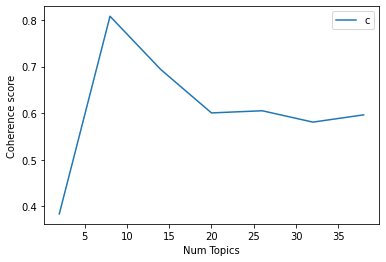

In [25]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [26]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3837
Num Topics = 8  has Coherence Value of 0.8081
Num Topics = 14  has Coherence Value of 0.6937
Num Topics = 20  has Coherence Value of 0.6005
Num Topics = 26  has Coherence Value of 0.6052
Num Topics = 32  has Coherence Value of 0.5808
Num Topics = 38  has Coherence Value of 0.5963


In [27]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.067*"set" + 0.067*"present" + 0.067*"vagueness" + 0.067*"utmost" + '
  '0.067*"uncertainty" + 0.067*"remark" + 0.067*"rough" + 0.067*"engineer" + '
  '0.067*"philosopher" + 0.067*"mathematician"'),
 (1,
  '0.120*"hand" + 0.080*"diversity" + 0.072*"indispensable" + '
  '0.063*"exploration" + 0.062*"consist" + 0.061*"understand" + 0.059*"role" + '
  '0.059*"prior" + 0.057*"tool" + 0.057*"equip"'),
 (2,
  '0.398*"time" + 0.346*"rate" + 0.249*"problem" + 0.002*"state" + '
  '0.002*"test" + 0.002*"geometry" + 0.000*"inadequate" + 0.000*"date" + '
  '0.000*"introduce" + 0.000*"instant"'),
 (3,
  '0.215*"science" + 0.201*"wide" + 0.199*"variety" + 0.180*"computer" + '
  '0.150*"paper" + 0.048*"field" + 0.005*"history" + 0.002*"geometry" + '
  '0.000*"represent" + 0.000*"representation"'),
 (4,
  '0.536*"knowledge" + 0.246*"computer" + 0.209*"current" + 0.006*"time" + '
  '0.002*"develop" + 0.002*"scientist" + 0.000*"economic" + 0.000*"arise" + '
  '0.000*"comp" + 0.000*"date"'),
 (5

In [28]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,7.0,0.3221,"input, size, rapidly, scenario, work, theory, ...","In the data stream scenario, input arrives ve..."
1,1,16.0,0.2573,"ago, classical, small, read, proud, confirm, c...",I actually own a copy of Harold Jeffreysâs ...
2,2,11.0,0.1849,"computational, survey, fundamental, demonstrat...",This paper presents a survey of the Voronoi d...
3,3,14.0,0.2656,"mining, discovery, database, attention, attrac...",Data mining and knowledge discovery in databa...
4,4,5.0,0.1944,"hand, research, community, variety, develop, c...",Data analysis plays an indispensable role for...
5,5,9.0,0.1983,"threshold, effective, image, test, find, stati...",Finding objective and effective thresholds fo...
6,6,19.0,0.1794,"temporal, base, area, arise, inadequate, comp,...",The problem of representing temporal knowledg...
7,7,6.0,0.2917,"decision, economic, rationality, series, text,...","economics, rationality Most real decisions, u..."
8,8,0.0,0.2536,"set, present, vagueness, utmost, uncertainty, ...",Abstract. This article presents some general ...
9,9,8.0,0.2961,"model, flow, function, loss, bulk, round, send...",In this paper we develop a simple analytic ch...


In [29]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.2568,"set, present, vagueness, utmost, uncertainty, ...",Abstract. This article presents some general ...
1,1.0,0.2008,"hand, diversity, indispensable, exploration, c...",Data analysis plays an indispensable role for...
2,5.0,0.2119,"hand, research, community, variety, develop, c...",Data analysis plays an indispensable role for...
3,6.0,0.2998,"decision, economic, rationality, series, text,...","economics, rationality Most real decisions, u..."
4,7.0,0.3251,"input, size, rapidly, scenario, work, theory, ...","In the data stream scenario, input arrives ve..."


In [30]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,7.0,"input, size, rapidly, scenario, work, theory, ...",100.0,0.100
1.0,16.0,"ago, classical, small, read, proud, confirm, c...",56.0,0.056
2.0,11.0,"computational, survey, fundamental, demonstrat...",NaN,NaN
3.0,14.0,"mining, discovery, database, attention, attrac...",NaN,NaN
4.0,5.0,"hand, research, community, variety, develop, c...",NaN,NaN
...,...,...,...,...
995.0,18.0,"threshold, objective, control, neuroimaging, l...",NaN,NaN
996.0,10.0,"base, temporal, science, line, relative, insta...",NaN,NaN
997.0,6.0,"decision, economic, rationality, series, text,...",NaN,NaN
998.0,0.0,"set, present, vagueness, utmost, uncertainty, ...",NaN,NaN


## (2) (15 points) Generate K topics by using LSA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

In [31]:
# Write your code here

import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

In [32]:
def load_data(path,file_name):
    """
    Input  : path and file_name
    Purpose: loading text file
    Output : list of paragraphs/documents and
             title(initial 100 words considred as title of document)
    """
    documents_list = []
    titles=[]
    with open( os.path.join(path, file_name) ,"r", encoding='unicode_escape') as fin:
        for line in fin.readlines():
            text = line.strip()
            documents_list.append(text)
    print("Total Number of Documents:",len(documents_list))
    titles.append( text[0:min(len(text),100)] )
    return documents_list,titles

def preprocess_data(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts

def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

Total Number of Documents: 1001
[(0, '0.546*"data" + 0.257*"knowledg" + 0.196*"input" + 0.186*"discoveri" + 0.163*"databas" + 0.163*"mine" + 0.161*"survey" + 0.144*"one" + 0.142*"model" + 0.134*"diagram"'), (1, '0.499*"decis" + 0.374*"quo" + 0.374*"statu" + 0.249*"make" + 0.249*"econom" + 0.133*"unlik" + 0.125*"previou" + 0.125*"oneâ" + 0.125*"bia" + 0.125*"noth"'), (2, '0.474*"model" + -0.251*"knowledg" + 0.229*"flow" + 0.229*"throughput" + 0.229*"tcp" + 0.229*"simpl" + 0.148*"rate" + 0.131*"function" + -0.124*"mine" + -0.124*"databas"'), (3, '0.326*"survey" + 0.308*"voronoi" + 0.308*"diagram" + -0.307*"knowledg" + -0.215*"discoveri" + 0.205*"fundament" + 0.205*"structur" + -0.201*"databas" + -0.201*"mine" + 0.171*"comput"'), (4, '0.446*"input" + -0.238*"knowledg" + 0.223*"less" + 0.223*"size" + 0.223*"stream" + 0.212*"algorithm" + -0.160*"tempor" + -0.156*"comput" + 0.155*"data" + -0.149*"survey"'), (5, '-0.386*"threshold" + -0.257*"neuroimag" + -0.257*"statist" + -0.223*"rate" + -0.

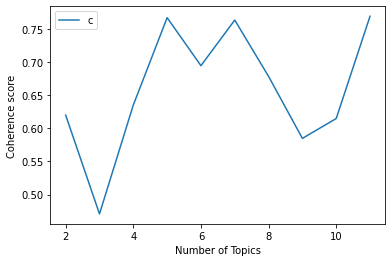

In [33]:
number_of_topics=7
words=10
document_list,titles = load_data("","romal_inclass4.csv")
clean_text=preprocess_data(document_list)
model=create_gensim_lsa_model(clean_text,number_of_topics,words)

start,stop,step=2,12,1
plot_graph(clean_text,start,stop,step)

## (3) (10 points) Compare the results generated by the two topic modeling algorithms, which one is better? You should explain the reasons in details.

In [34]:
# Write your answer here (no code needed for this question)
# In the LDA model, the perplexity is apromimately -3 which means that the first model is good because lower value of perplexity tells us 
# that the model is good. The coherence score is 0.80 which also signifies that the model is good(The more the CV value the better it is). 
# The number of optimal topics that have the highest coherence value is 8. The highest coherence for the LSA model is more than 0.75(from the graph above). I feel that
# LSA model was much faster to run as compared to the LDA model. The LDA model also had more complexity in terms of creating the matrices as
# compared to the LSA model. Both the graphs have their own advantages and disadvantages and it really depends on the kind of data and what are
# goals are while working with these two models.

